<a href="https://colab.research.google.com/github/NinaMwangi/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset

In [ ]:
# Loading the dataset
# data = pd.read_csv('Reviews.csv')
data = pd.read_csv('/content/drive/MyDrive/Sentiment Analysis/archive-2/Reviews.csv')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Exploratory Data Analysis

In [ ]:
# Checking the shape of the data
data.shape

(568454, 10)

In [ ]:
# Downsizing to work with a manageable quantity of the data
data = data.head(20000)
data.shape

(20000, 10)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      20000 non-null  int64 
 1   ProductId               20000 non-null  object
 2   UserId                  20000 non-null  object
 3   ProfileName             19999 non-null  object
 4   HelpfulnessNumerator    20000 non-null  int64 
 5   HelpfulnessDenominator  20000 non-null  int64 
 6   Score                   20000 non-null  int64 
 7   Time                    20000 non-null  int64 
 8   Summary                 20000 non-null  object
 9   Text                    20000 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.5+ MB


In [ ]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04
mean,10000.500000,1.612050,2.085050,4.160500,1.294720e+09
std,5773.647028,5.497996,6.170617,1.315343,4.743663e+07
min,1.000000,0.000000,0.000000,1.000000,9.617184e+08
25%,5000.750000,0.000000,0.000000,4.000000,1.269216e+09
50%,10000.500000,0.000000,1.000000,5.000000,1.307923e+09
75%,15000.250000,2.000000,2.000000,5.000000,1.330474e+09
max,20000.000000,202.000000,219.000000,5.000000,1.351210e+09


In [ ]:
# Checking for the number of times each score occurs and sorting
data['Score'].value_counts().sort_index()

,count
Score,
1,1824
2,1120
3,1649
4,2836
5,12571


# Data Visualization

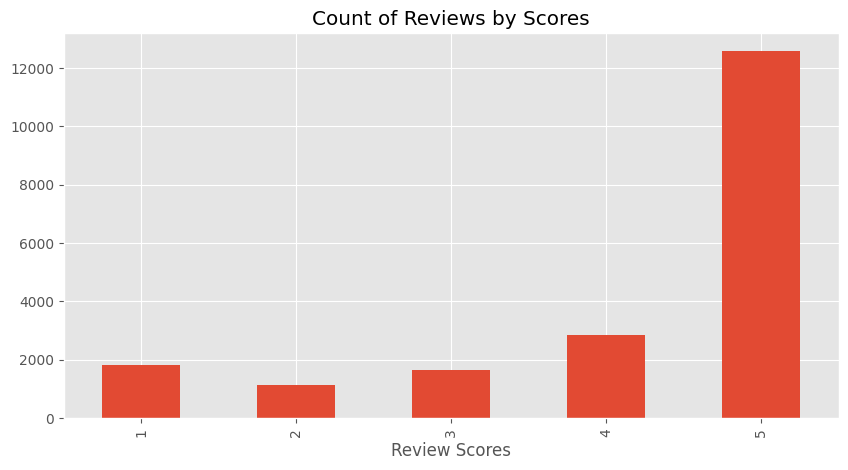

In [ ]:
# plotting the count of reviews by score.
ax = data['Score'].value_counts().sort_index()\
    .plot(kind='bar',
          title='Count of Reviews by Scores',
          figsize=(10, 5))
ax.set_xlabel('Review Scores')
plt.show()

Plotting the count of the reviews against the scores i.e stars reveals to us that there are more 5 star reviews in this dataset compared to the other stars. This dataset has a positive bias, we observed an uptick in the 4 stars and 1 star reviews as well and noted that the lowest count is in the 2 star rating.

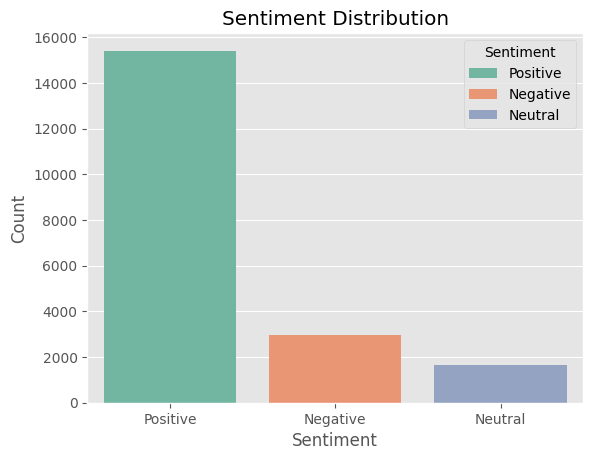

In [ ]:
# Create sentiment labels
data['Sentiment'] = data['Score'].apply(lambda x: 'Positive' if x >= 4 else 'Negative' if x <= 2 else 'Neutral')

# Plot sentiment distribution
sns.countplot(x='Sentiment', hue='Sentiment', data=data, palette='Set2', legend=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

This distribution of sentiment, is where X-axis represents the sentiment catergories where 3: is Netural, 1,2: is Negative, and 4,5: is Positive; while Y-axis is show the number of reponse on that sentiment. this reveals whether there's a significant imbalance between sentiment classes. and this distribution can inform decision about to use techniques to handle class imbalance.

# Preprocessing the Text
In this section we have preprocessed the data using NLTK. We have removed the stopwords and punctutaions in the data. We have also converted the data to lowercase and lemmatised the word back to their basic form.

In [ ]:
# Downloading the stopword, wordnet and omw-1.4 using NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Joining the text column into one big review string
text = ' '.join(review for review in data['Text'].astype(str))

# Removing punctuation and numbers
text = re.sub(r'[^a-zA-Z\s]', ' ', text)

# Converting to lowercase
text = text.lower()

# Removing stopwords
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

text = ' '.join(lemma.lemmatize(word) for word in text.split() if word not in stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Word cloud visualisation
We are creating a word cloud to display the text column in a bid to visualise the words frequently used in the reviews and to show their importance.

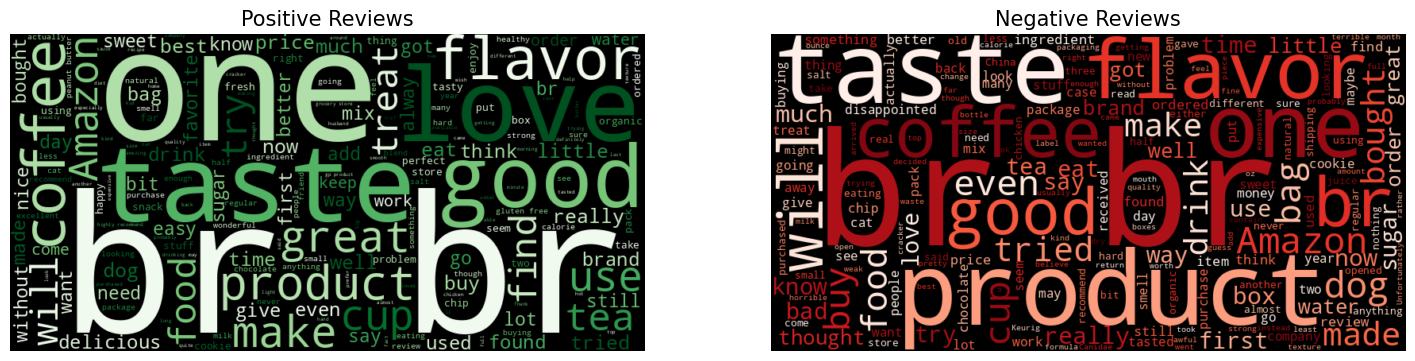

In [ ]:
# separating by sentiment
positive = data[data['Score'] >= 4]['Text']
negative = data[data['Score'] <= 2]['Text']

# Combining all the texts for each sentiment.
positive_text = ' '.join(positive)
negative_text = ' '.join(negative)

# Creating the wordcloud object.
positive_wc = WordCloud(width = 800, height=400, background_color='black', colormap='Greens').generate(positive_text)
negative_wc = WordCloud(width = 800, height=400, background_color='black', colormap='Reds').generate(negative_text)

#Displaying the wordcloud
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews', fontsize=15)
plt.show

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews', fontsize=15)
plt.show()

# Length Versus Sentiment Visualisation
We plotted the length of the sentiment against reviews to see how long the reviews are and if length differs by sentiment.

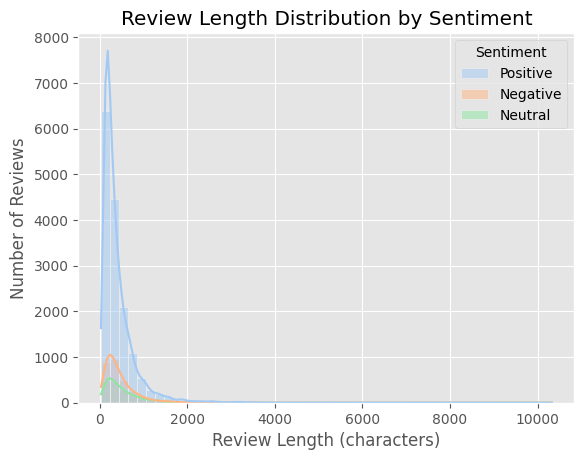

In [ ]:
data['Review_Length'] = data['Text'].astype(str).apply(len)

# Plot by sentiment categories
data['Sentiment'] = data['Score'].apply(lambda x: 'Positive' if x >= 4 else ('Negative' if x <= 2 else 'Neutral'))

sns.histplot(data=data, x='Review_Length', hue='Sentiment', bins=50, kde=True, palette='pastel')
plt.title('Review Length Distribution by Sentiment')
plt.xlabel('Review Length (characters)')
plt.ylabel('Number of Reviews')
plt.show()


## Label Encoding Sentiment
- This particular block of code is performing semantic mapping from the score column to sentiment category. This is so that we can have multiclass sentiment classification.
- We are then using LabelEncoder to convert those label to numeric form for our models.

In [ ]:
def label_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score <= 2:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['Score'].apply(label_sentiment)

label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment'])

# One hot encoding
labels = to_categorical(data['label'])

# confirming the mapping
print(data[['sentiment', 'label']].value_counts())
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

sentiment  label
positive   2        15407
negative   0         2944
neutral    1         1649
Name: count, dtype: int64
{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


## Preprocessing Individual Reviews
The initial preprocessing was done on the big string that had been created to help in creating the word cloud. However now we are preprocessing each review and storing it in a new column titled clean_text, using the preprocess function.

In [ ]:
def preprocess(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    words = [lemma.lemmatize(word) for word in words]
    return ' '.join(words)

data['clean_text'] = data['Text'].apply(preprocess)
print(data[['Score', 'sentiment', 'clean_text']].head())

   Score sentiment                                         clean_text
0      5  positive  bought several vitality canned dog food produc...
1      1  negative  product arrived labeled jumbo salted peanut pe...
2      4  positive  confection around century light pillowy citrus...
3      2  negative  looking secret ingredient robitussin believe f...
4      5  positive  great taffy great price wide assortment yummy ...


# Tokenizing and Padding
Here we are separating the clean_text column into words through tokenizing, creating and padding the sequence.

In [ ]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['clean_text'])

# Creating our sequence
sequences = tokenizer.texts_to_sequences(data['clean_text'])

# padding the sequence
maxlen = 100
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [ ]:
# Splitting data into train and test
X = padded_sequences
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['label'].values)

## Glove Embeddings

In [ ]:
embedding_index = {}
embedding_dim = 100
glove_path = '/content/drive/MyDrive/Sentiment Analysis/glove/glove.6B.100d.txt'

with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

# Creating the embedding Matrix
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors from GloVe.


# GRU MODEL

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    trainable=False))

model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Stoping training when val_loss doesn't improve after 3 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Saving the best model based on validation loss
checkpoint = ModelCheckpoint(
    'best_gru_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


## Compiling and training the model

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[early_stop, checkpoint])

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.8112 - loss: 0.5154
Epoch 1: val_loss improved from 0.53631 to 0.53627, saving model to best_gru_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 76s 724ms/step - accuracy: 0.8112 - loss: 0.5155 - val_accuracy: 0.7984 - val_loss: 0.5363
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8051 - loss: 0.5174
Epoch 2: val_loss improved from 0.53627 to 0.53599, saving model to best_gru_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 696ms/step - accuracy: 0.8051 - loss: 0.5174 - val_accuracy: 0.7959 - val_loss: 0.5360
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.8022 - loss: 0.5285
Epoch 3: val_loss improved from 0.53599 to 0.52508, saving model to best_gru_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 84s 720ms/step - accuracy: 0.8023 - loss: 0.5284 - val_accuracy: 0.8050 - val_loss: 0.5251
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8128 - loss: 0.5104
Epoch 4: val_loss did

## Evaluating the model

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8136 - loss: 0.5168
Test Accuracy: 0.8080


# LSTM Model

In [ ]:
# Splitting data into train and test
X = padded_sequences
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['label'].values)

# Define model
model_1 = Sequential()
model_1.add(Embedding(input_dim=10000, output_dim=128))
model_1.add(LSTM(64, return_sequences=True))
model_1.add(Dropout(0.3))
model_1.add(LSTM(32))
model_1.add(Dropout(0.3))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(3, activation='softmax'))

# Compile with custom learning rate
optimizer = Adam(learning_rate=0.001)
model_1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Early stopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model_1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

In [ ]:
# Evaluate and predict
y_pred_prb = model_1.predict(X_test)
y_pred = np.argmax(y_pred_prb, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [ ]:
# Model evaluation
loss, accuracy = model_1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Linear Regression Model

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    max_features=40000,
    ngram_range=(1, 2),
    stop_words='english',
    dtype=np.float32
)

# Fit the vectorizer on the text data and transform it into TF-IDF features
X = tfidf_vectorizer.fit_transform(data['clean_text'])

# Target variable
y = data['Sentiment']

# Train & Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

In [ ]:
# Evaluate the Model
y_pred = lr_model.predict(X_test)

# Print Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))

In [ ]:
# Predict using lr_model
y_pred = lr_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Auto-detect labels from model
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 100],
    'penalty': ['l1','l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
}

# Apply GridSearchCV
grid_search = GridSearchCV(estimator=lr_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Fit on training data
grid_search.fit(X_train, y_train)

In [ ]:
# Print the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

### **Naive Bayes**

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9
)
X = tfidf.fit_transform(data['Text'])
y = data['Sentiment']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train the Naive Bayes model
nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train, y_train)

In [ ]:
# Predict and evaluate
y_pred = nb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Predict using lr_model
y_pred = nb_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Auto-detect labels from model
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

## **Support Vector Machine (SVM) for Sentiment Classification**

In [ ]:
svm_model = LinearSVC(class_weight='balanced', C=0.8)
svm_model.fit(X_train, y_train)

In [ ]:
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

In [ ]:
# Predict using lr_model
y_pred = svm_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Auto-detect labels from model
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for SVM')
plt.show()